# OpenFEMA NFIP Redacted Policies Tutorial

## Overview
The NFIP Redacted Policies OpenFEMA dataset provides the public with "real" information on NFIP policy transactions. It is derived from the NFIP system of record, staged in the NFIP reporting platform and redacted to protect policy holder personally identifiable information (PII).

This notebook will provide common examples of basic statistics related to NFIP policies using methodologies employed by FEMA. This notebook only scratches the surface of what is possible - an introduction to the types of analytics can be performed using the OpenFEMA NFIP Policies dataset.

<u>List of Examples</u>
 - [Create a Function to Call Specific Data](#Create-a-Function-to-Call-Specific-Data) 
 - [Policies In-Force for the State of Utah](#Example:-State-of-Utah) (Includes "paging" bypass function)
 - [Historical Policies In-Force Table](#Historical-Policies-In-Force-Table)
 - [Visualization of Policies In-Force](#Visualize-Data)
 - [Monthly Policies In-Force Counts](#Monthly-Policies-In-Force-Counts)
 - [Save Table to CSV](#Save-Table-to-CSV)
 - [Plot Time Series Graph](#Plot-Time-Series-Graph)
 - [Table of Mean/Median/Min/Max Policy Cost (2020-2024)](#Table-of-Mean/Median/Min/Max-Policy-Cost-(2020-2024))
 - [Mean Policy Cost by Year Bar Chart](#Mean-Policy-Cost-by-Year-Bar-Chart)
 - [Top 5 County Policy Cost Table](#Top-5-County-Policy-Cost-Table)
 - [Box and Whisker Plots](#Box-and-Whisker-Plots)
 - [Community Policy Table](#Community-Policy-Table)
 - [PIF in / out SFHA](#PIF-in-/-out-SFHA)
 - [Utah Policies in Force as of Jan 1, 2021 Map](#Utah-Policies-in-Force-as-of-Jan-1,-2021-Map)
 - [Utah Policies in Force as of Jan 1, 2024 Map](#Utah-Policies-in-Force-as-of-Jan-1,-2024-Map)
 - [Year-over-Year 1-year policy growth map](#Year-over-Year-1-year-policy-growth-map)
 - [Utah Median Policy Cost as of Jan 1, 2021 Map](#Utah-Median-Policy-Cost-as-of-Jan-1,-2021-Map)
 - [Median Policy Costs on January 1, 2024 by Utah County](#Median-Policy-Costs-on-January-1,-2024-by-Utah-County)
 - [Year-over-Year Median Policy Cost Map](#Year-over-Year-Median-Policy-Cost-Map)

## Disclaimers
 - **This Jupyter notebook and the examples presented are not intended to be an official federal report.**
 - The focus of this nootbook is on data access and data manipulation with readily available tools. This is not meant to be a deep, insightful analysis of NFIP data. It is also not meant to be a Python language tutorial.
 - Although the examples are presented using Python 3, it should be easy to translate them to almost any programming language.

## Create a Function to Call Specific Data

After importing the necessary libraries, we will create a function to call only the requisite data for our analysis. This function will include basic parameters (i.e. state and as-of-date) to subset the data request, improving performance. Due to the default cap in the number of records (i.e. 10,000) returned per API call, we will loop through the records, append the results of each call to a data frame, and continue until we reach the total number of records. 

In [15]:
# import the necessary libraries
import pandas as pd
import requests
import warnings
import time
from datetime import datetime
import matplotlib.pyplot as plt
# Use colorblind-friendly color cycle
plt.style.use('tableau-colorblind10')  
# Turn off warnings
warnings.filterwarnings('ignore', category=FutureWarning)

<div class="alert alert-block alert-warning">
    <b>Note:</b> The \$filter reflects the 'policy in-force' logic that checks to make sure a given policy (i.e. policy period) has not: 1) elapsed as of a given date, 2) been cancelled as of the date in question, or 3) if the policy has been cancelled, then the cancellation effective date exists in the future.
</div>

In [17]:
# create a function that will call the OpenFEMA API and return filtered data based off of selected state parameter
def fetch_policies_data(state_filter,
                        as_of_date,
                        base_url="https://www.fema.gov/api/open/v2/FimaNfipPolicies",
                        record_limit=10000):
    policies_data = pd.DataFrame()
    skip_records = 0
    start_time = time.time()  # Start time measurement
    
    while True:
        print(f"Fetching data starting from record {skip_records}...") 
        #start_time = time.time()  # Start time measurement
        
        url = f"{base_url}?$filter=propertyState eq '{state_filter}' and policyEffectiveDate le '{as_of_date}\
        ' and policyTerminationDate gt '{as_of_date}\
        ' and (cancellationDateOfFloodPolicy eq null or cancellationDateOfFloodPolicy gt '{as_of_date}\
        ')&$top={record_limit}&$skip={skip_records}&$format=json"
        
        
        try:
            response = requests.get(url, timeout=60)  # Timeout of 60 seconds for the request
            
            if response.status_code == 200: # Indicates the request has succeeded
                data = response.json().get("FimaNfipPolicies", [])
                if not data:
                    break  # Break the loop if no more data is returned
                
                new_data_df = pd.DataFrame(data)
                policies_data = pd.concat([policies_data, new_data_df], ignore_index=True)
                skip_records += record_limit
            else:
                print(f"Failed to fetch data: HTTP {response.status_code}")
                break  # Break the loop on failure
            
        except requests.exceptions.Timeout:
            print("Request timed out. Consider reducing 'record_limit' or trying again later.")
            break  # Break the loop if a request times out
        
    end_time = time.time()  # End time measurement
    print(f"Fetched {len(policies_data)} records in {end_time - start_time:.2f} seconds.")  # Print how long the request took
    print(f"Done.")
    return policies_data

<div class="alert alert-block alert-info">
    <b>Tip:</b> The above code retrieves data using a technique called "paging". Since OpenFEMA only returns data in chunks up to 10,000 records per call, it is necessary to perform multiple iterations to get all the data. <br><br>In February 2024, OpenFEMA added a new argument, \$allrecords. When used, all records will be returned without needing to issue multiple calls. This will reduce code complexity and improve performance. This argument is currently in beta - you can use it, but if it is found that the OpenFEMA servers are being negatively impacted, it may be limited or removed. <br><br>This feature is especially useful for large datasets such as NFIP, where large \$skip values begin to impact download times and may even cause timeouts.
</div>

<div class="alert alert-block alert-warning">
    <b>Note:</b> Most of the examples presented in this notebook retrieve data using the "paging" technique as many were written before the \$allrecords argument was made public.
</div>

The following function is an alternative to the above that does not use paging. It also has an added parameter to limit the fields that are returned. Many of the examples presented return all the fields for the specified Policy data. Use the $select argument to specify a comma-delimited list of the fields you want to return when only a few are needed. This will result in significantly faster downloads and use less memory - essentally improving performance.

In [18]:
# An alternative to the above function that bypasses"paging"
# create a function that will call the OpenFEMA API and return filtered data based off of selected state parameter
def fetch_policies_data_no_paging(state_filter,
                        as_of_date,
                        base_url="https://www.fema.gov/api/open/v2/FimaNfipPolicies",
                        select=""):
    
    print(f"Fetching data...") 
    start_time = time.time()  # Start time measurement

    url = f"{base_url}?$filter=propertyState eq '{state_filter}' and policyEffectiveDate le '{as_of_date}\
    ' and policyTerminationDate gt '{as_of_date}\
    ' and (cancellationDateOfFloodPolicy eq null or cancellationDateOfFloodPolicy gt '{as_of_date}\
    ')&$allrecords=true&$format=json"

    if select != "":
        url = url + '&$select=' + select
        
    try:
        response = requests.get(url)  

        if response.status_code == 200: # Indicates the request has succeeded
            data = response.json().get("FimaNfipPolicies", [])
            
            # turn into data frame
            policies_data = pd.DataFrame(data)
        else:
            print(f"Failed to fetch data: HTTP {response.status_code}")
            
    except requests.exceptions.RequestException as e: 
        #raise SystemExit(e)
        print(e)
        
    end_time = time.time()  # End time measurement
    print(f"Fetched {len(data)} records in {end_time - start_time:.2f} seconds.")  # Print how long the request took
    print(f"Done.")
    return policies_data

## Example: State of Utah
In this tutorial, we will focus on the state of **Utah** for policies in-force on **January 1, 2024**. 

Now that we have defined our function, we need to specify the parameters to call the desired data. We will select only the state of Utah by using it's two-letter abbreviation and identifying the as-of-date (i.e. January 1, 2024). We will store these results in a new pandas data frame called "policies_data" which we can then reference going forward. 

In [19]:
# This uses the first function that pages to get data
state_filter = 'UT' #Utah 2-letter code
as_of_date = '2024-01-01' #Set policy in-force as of date
policies_data = fetch_policies_data(state_filter=state_filter, as_of_date = as_of_date) # run function and store results in new object

Fetching data starting from record 0...
Fetching data starting from record 10000...
Fetched 6885 records in 3.45 seconds.
Done.


In [20]:
# this example uses the second function that does not use paging - it also limits the return to a few fields
# by limiting fields, far less memory is used
state_filter = 'UT' #Utah 2-letter code
as_of_date = '2024-01-01' #Set policy in-force as of date
select_clause = 'policyEffectiveDate,cancellationDateOfFloodPolicy,policyTerminationDate,policyCount,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage'
policies_data = fetch_policies_data_no_paging(state_filter=state_filter, as_of_date = as_of_date,select=select_clause)

Fetching data...
Fetched 6885 records in 0.88 seconds.
Done.


In [21]:
# this example uses the second function without paging
state_filter = 'UT' #Utah 2-letter code
as_of_date = '2024-01-01' #Set policy in-force as of date
policies_data = fetch_policies_data_no_paging(state_filter=state_filter, as_of_date = as_of_date) # run function and store results in new object

Fetching data...
Fetched 6885 records in 3.05 seconds.
Done.


Now that the data has been pulled, let's take a look at what it actually looks like. We've stored the results in what is known as a *pandas* dataframe which resembles an Excel spreadsheet or CSV. We can reference the data in the cells by applying functions to our new policies_data object. 

For example, let's take a look at the first few entries of the data set.

In [22]:
policies_data.head()

,agricultureStructureIndicator,baseFloodElevation,basementEnclosureCrawlspaceType,cancellationDateOfFloodPolicy,condominiumCoverageTypeCode,construction,crsClassCode,buildingDeductibleCode,contentsDeductibleCode,elevatedBuildingIndicator,...,femaRegion,propertyState,reportedCity,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,id
0,False,NaN,NaN,None,N,False,NaN,2,2,False,...,8.0,UT,Currently Unavailable,84741,49025,49025130200,490251302004,37.1,-112.5,4793c3e2-def8-435c-856d-8b6ff3ee9875
1,False,NaN,1.0,None,U,False,NaN,F,1,False,...,8.0,UT,Currently Unavailable,84043,49049,49049010216,490490102162,40.4,-111.8,8dd956aa-ed0f-4848-ab6f-a59d377bdacb
2,False,NaN,NaN,None,N,False,NaN,F,None,True,...,8.0,UT,Currently Unavailable,84119,49035,49035113305,490351133051,40.7,-111.9,d0bb39d8-39f5-4108-9d80-61a393ec68dd
3,False,NaN,NaN,None,N,False,NaN,F,1,True,...,8.0,UT,Currently Unavailable,84040,49011,49011125102,490111251021,41.1,-111.9,84f92073-7caa-4fd2-ba73-9827f5772626
4,False,NaN,1.0,None,N,False,NaN,2,1,False,...,8.0,UT,Currently Unavailable,84108,49035,49035110103,490351101031,40.8,-111.8,7e1e6697-41e8-48e8-8abc-e4dfb8cc293b


We can use the **shape** command to figure out the dimensions of the data set. We see there are about 7,000 rows (i.e. NFIP contracts) and 81 columns in this data set. 

In [23]:
policies_data.shape

(6885, 81)

Next, let's calculate the number of "policies in-force" in the state of Utah as of January 1, 2024. To do so, we will sum the *policyCount* field for each policy period. 

<div class="alert alert-block alert-warning">
    <b>Note: What is the difference between an NFIP “contract” and “policy”?</b>
Each NFIP policyholder has an NFIP contract insuring either their structure, their contents, or both. NFIP policies are associated with contracts and sometimes count individual units covered as part of a contract within a larger structure. There is always at least one policy associated with each contract. For example, a policyholder insuring their single-family home for building and contents coverage holds one NFIP contract with a single, associated policy. For condominiums, however, a single NFIP contract may be issued to the policyholder (usually a condominium association) which may insure individual residential units therein. In this instance, the NFIP policyholder would hold a single contract with multiple policies for each covered unit.
</div>

In [24]:
# Get the count of policies in-force
total_policies_in_force = policies_data['policyCount'].sum()

# Print the sum of policies in force
print(f"Total number of policies in force on {as_of_date} for state {state_filter}: {total_policies_in_force}")

Total number of policies in force on 2024-01-01 for state UT: 7498


## Historical Policies In-Force Table

If we want to create a time series of policies in force counts, we will need to pull more than one years' worth of data. We'll create a new function to pull multiple years, while also including a parameter (*start_date*) to lessen the size of the query by only looking at policies a year prior to our start date. For standard flood insurance policies, those effective on a given date have effective dates going back one year (e.g. a policy in force on January 1, 2024, could have an effective date as far back as January 1, 2023).

In [25]:
# create a function that will call the OpenFEMA API and return filtered data based off of selected state parameter
def fetch_policies_data(state_filter, start_date, base_url="https://www.fema.gov/api/open/v2/FimaNfipPolicies", record_limit=10000):
    policies_data = pd.DataFrame()
    skip_records = 0
    start_time = time.time()  # Start time measurement
    
    while True:
        print(f"Fetching data starting from record {skip_records}...") 
        
        url = f"{base_url}?$filter=propertyState eq '{state_filter}' and policyEffectiveDate ge '{start_date}'&$top={record_limit}&$skip={skip_records}&$format=json"
        
        try:
            response = requests.get(url, timeout=60)  # Timeout of 60 seconds for the request
            
            if response.status_code == 200: # Indicates the request has succeeded
                data = response.json().get("FimaNfipPolicies", [])
                if not data:
                    break  # Break the loop if no more data is returned
                
                new_data_df = pd.DataFrame(data)
                policies_data = pd.concat([policies_data, new_data_df], ignore_index=True)
                skip_records += record_limit
            else:
                print(f"Failed to fetch data: HTTP {response.status_code}")
                break  # Break the loop on failure
            
        except requests.exceptions.Timeout:
            print("Request timed out. Consider reducing 'record_limit' or trying again later.")
            break  # Break the loop if a request times out
        
    end_time = time.time()  # End time measurement
    print(f"Fetched {len(policies_data)} records in {end_time - start_time:.2f} seconds.")  # Print how long the request took
    print(f"Done.")
    return policies_data

For this example we'll look at records in Utah from 2020 to 2024.

In [26]:
state_filter = 'UT' # Utah
start_date = '2019-01-01' # for Policies in 2020 or later
policies_data = fetch_policies_data(state_filter=state_filter, start_date = start_date)

Fetching data starting from record 0...
Fetching data starting from record 10000...
Fetching data starting from record 20000...
Fetching data starting from record 30000...
Fetched 23222 records in 11.51 seconds.
Done.


Next, we'll create a function to filter the data using our policy in-force logic, loop through the years of interest, and append the results to a list. Last, we'll print the results to a pandas data frame. 

In [27]:
def filter_policies_in_force(policies_data, date_str):
    """Filters policies to find those in force based on the provided date."""
    # String date converted to datetime for comparison
    date = datetime.fromisoformat(date_str.rstrip("Z"))
    
    # Convert to datetime and coerce out-of-bounds dates to NaT
    policies_data['policyEffectiveDate'] = pd.to_datetime(policies_data['policyEffectiveDate'], errors='coerce').dt.tz_localize(None)
    policies_data['policyTerminationDate'] = pd.to_datetime(policies_data['policyTerminationDate'], errors='coerce').dt.tz_localize(None)
    policies_data['cancellationDateOfFloodPolicy'] = pd.to_datetime(policies_data['cancellationDateOfFloodPolicy'], errors='coerce').dt.tz_localize(None)
    
    # Apply in force logic
    policies_in_force = policies_data[
        (policies_data['policyEffectiveDate'] <= date) &
        (policies_data['policyTerminationDate'] > date) &
        (
            pd.isnull(policies_data['cancellationDateOfFloodPolicy']) | 
            (policies_data['cancellationDateOfFloodPolicy'] > date)
        )
    ]
    
    return policies_in_force

# from datetime import datetime
# import pandas as pd

# Get the current date
current_date = datetime.now()

# Get the current year
current_year = current_date.year

# Create a range from 10 years ago to the current year
years = range(current_year - 4, current_year + 1)  # From 2020 to 2024
# python is not inclusive of the last year, so we need to add a year to get the current year

data_list = []

# Use a for loop to cycle through each year
for year in years: # for each year in "years"
    date_str = f"{year}-01-01T00:00:00.000Z" # assign timestamp to object 'date_str'

    policies_in_force = filter_policies_in_force(policies_data, date_str) # run the function and store output
    total_policies_in_force = policies_in_force['policyCount'].sum() if 'policyCount' in policies_in_force else 0 # sum policy count
    data_list.append({'Year': year, 'PoliciesInForce': total_policies_in_force}) # store results in list

# Create DataFrame from the list of data
policies_summary = pd.DataFrame(data_list)

# Print the DataFrame without the index
#print(policies_summary.to_string(index=False))
policies_summary


,Year,PoliciesInForce
0,2020,3981
1,2021,3761
2,2022,3838
3,2023,3791
4,2024,7498


## Visualize Data
Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python. We can use this package to visualize the data to help recognize trends at a glance. We start by plotting the above table in graphical format using a basic line graph.

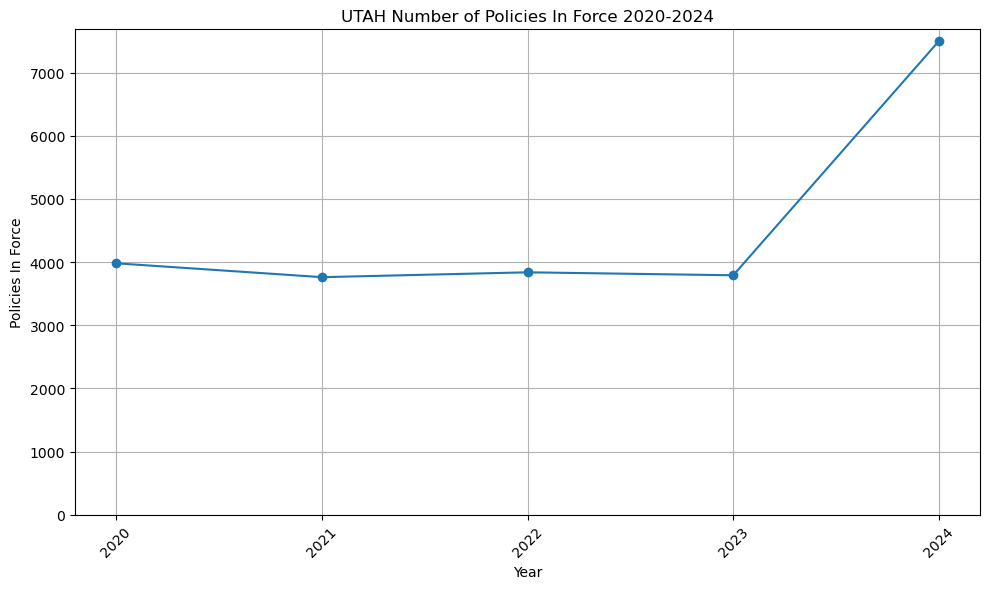

In [10]:
# Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python
import matplotlib.pyplot as plt

policies_summary['Year'] = pd.to_datetime(policies_summary['Year'], format='%Y') # Convert Year column to datetime data type

plt.figure(figsize=(10, 6))
plt.plot(policies_summary['Year'], policies_summary['PoliciesInForce'], marker='o', linestyle='-', color='tab:blue')

plt.title('UTAH Number of Policies In Force 2020-2024')
#plt.suptitle('as of January')
plt.xlabel('Year')
plt.ylabel('Policies In Force')
plt.grid(True)
plt.ylim(bottom=0) 

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From this plot, we see that there was a steady number of policies in force in the state of Utah from 2020 to 2023, but then a sudden uptick in the number of policies in 2024. 

## Monthly Policies In-Force Counts
We can take a closer look at policy trends at a more granular level. We'll start by taking a look at the monthly policy in force counts in Utah to see when the uptick in policies occurred. We will add some additional information to our data table, such as coverage amounts. 

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Set pandas display options for better DataFrame visualization
pd.set_option('display.max_rows', None)  # or set a specific number like 10
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 100)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 2)

# Assuming policies_data is already defined and loaded with the necessary data
policies_data['policyEffectiveDate'] = pd.to_datetime(policies_data['policyEffectiveDate'])
policies_data['policyTerminationDate'] = pd.to_datetime(policies_data['policyTerminationDate'], errors='coerce')
policies_data['cancellationDateOfFloodPolicy'] = pd.to_datetime(policies_data['cancellationDateOfFloodPolicy'], errors='coerce')


start_period = pd.to_datetime('2020-01-01') # set start date
end_period = pd.to_datetime('2024-01-01') # set end date
monthly_periods = pd.date_range(start_period, end_period, freq='MS') # create a range from start to end by month

monthly_policy_data = []

for month_start in monthly_periods:
    policies_in_force = policies_data[
        (policies_data['policyEffectiveDate'] <= month_start) &
        (policies_data['policyTerminationDate'] > month_start) &
        (
            pd.isnull(policies_data['cancellationDateOfFloodPolicy']) | 
            (policies_data['cancellationDateOfFloodPolicy'] > month_start)
        )
    ]

    total_policy_count = policies_in_force['policyCount'].sum()
    total_building_coverage = policies_in_force['totalBuildingInsuranceCoverage'].sum()
    total_contents_coverage = policies_in_force['totalContentsInsuranceCoverage'].sum()
    
    monthly_policy_data.append({
        'Month': month_start.strftime('%Y-%m'), 
        'PoliciesInForce': total_policy_count, 
        'TotalBuildingCoverage': total_building_coverage,
        'TotalContentsCoverage': total_contents_coverage,
        'TotalCoverage': total_building_coverage + total_contents_coverage
    })

df_monthly_data = pd.DataFrame(monthly_policy_data)

display(df_monthly_data)


,Month,PoliciesInForce,TotalBuildingCoverage,TotalContentsCoverage,TotalCoverage
0,2020-01,3981,833992800,251497500,1085490300
1,2020-02,3976,834433400,252493800,1086927200
2,2020-03,3964,832089600,251633400,1083723000
3,2020-04,3952,830952300,251093400,1082045700
4,2020-05,3873,815409900,247898900,1063308800
5,2020-06,3745,784988800,245380300,1030369100
6,2020-07,3762,790475400,248352800,1038828200
7,2020-08,3757,791626500,249601900,1041228400
8,2020-09,3776,799134900,252959300,1052094200
9,2020-10,3791,803504400,254272200,1057776600


## Save Table to CSV
We can save the results from our table to a comma separated value (CSV) table. 

In [12]:
import os 
# set your working directory (i.e. where you want to save the file to)
#path = ''
#os.chdir(path)

df_monthly_data.to_csv('monthly_policy_data.csv', index=False)

## Plot Time Series Graph
The best way to visualize this data perhaps is through a plot. Here we see the change in policies in force again using Matplotlib.

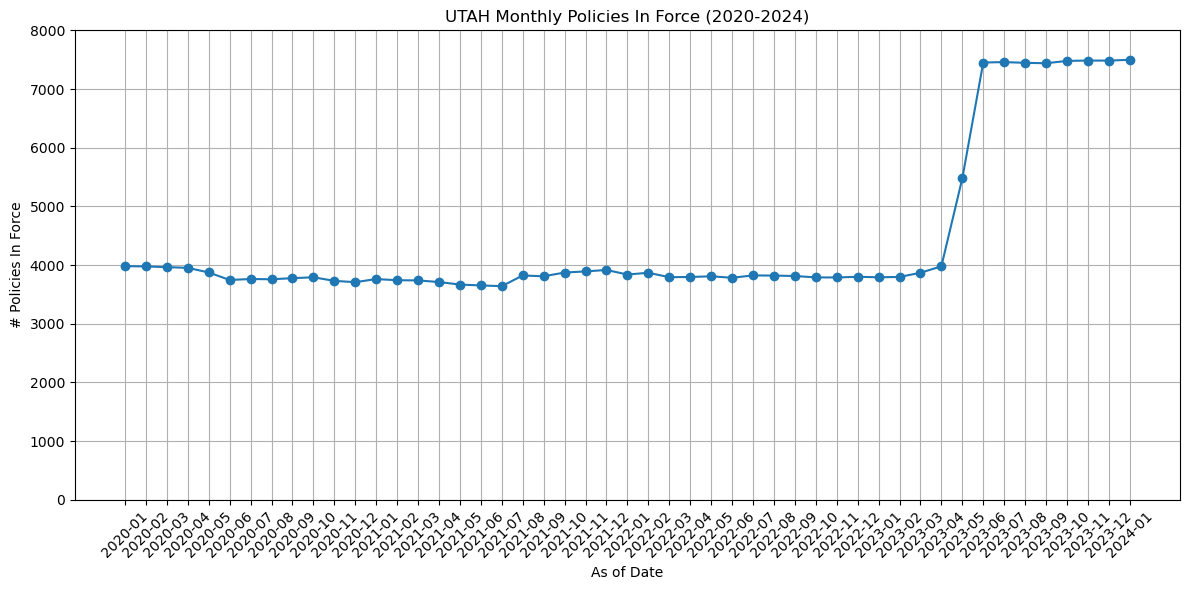

In [13]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(df_monthly_data['Month'], df_monthly_data['PoliciesInForce'], marker='o', linestyle='-', color='tab:blue')
plt.title('UTAH Monthly Policies In Force (2020-2024)')
plt.xlabel('As of Date')
plt.ylabel('# Policies In Force')
plt.ylim(bottom=0, top=8000) 
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Table of Mean/Median/Min/Max Policy Cost (2020-2024)
To calculate summary statistics about policy data, we can do so using pre-built functions in Python such as **mean**, **median**, **min**, and **max**. 

In [14]:
import pandas as pd

policies_data['policyEffectiveDate'] = pd.to_datetime(policies_data['policyEffectiveDate'])
policies_data['policyTerminationDate'] = pd.to_datetime(policies_data['policyTerminationDate'], errors='coerce')

years = range(2020, 2025)

annual_policy_stats = []

for year in years:
    specific_date = pd.Timestamp(year=year, month=1, day=1)
    
    # Filter the policies that are in force on the first day of each year
    policies_in_force_on_date = policies_data[
        (policies_data['policyEffectiveDate'] <= specific_date) &
        (policies_data['policyTerminationDate'] >= specific_date) &
        (pd.isnull(policies_data['cancellationDateOfFloodPolicy']) | 
         (policies_data['cancellationDateOfFloodPolicy'] > specific_date))
    ]
    
    # Calculate the statistics for policy cost
    min_policy_cost = policies_in_force_on_date['policyCost'].min()
    max_policy_cost = policies_in_force_on_date['policyCost'].max()
    median_policy_cost = policies_in_force_on_date['policyCost'].median()
    mean_policy_cost = policies_in_force_on_date['policyCost'].mean()
    
    annual_policy_stats.append({
        'Year': year,
        'Min Policy Cost': min_policy_cost,
        'Max Policy Cost': max_policy_cost,
        'Median Policy Cost': int(median_policy_cost),
        'Mean Policy Cost': int(mean_policy_cost)
    })

df_annual_policy_stats = pd.DataFrame(annual_policy_stats)

display(df_annual_policy_stats)

,Year,Min Policy Cost,Max Policy Cost,Median Policy Cost,Mean Policy Cost
0,2020,65,45394,534,991
1,2021,77,56697,572,1068
2,2022,105,70863,633,1091
3,2023,106,26868,687,884
4,2024,114,16582,624,825


## Mean Policy Cost by Year Bar Chart
The following code snippet creates a bar chart using *matplotlib* to visualize the mean NFIP policy costs over multiple years in Utah.

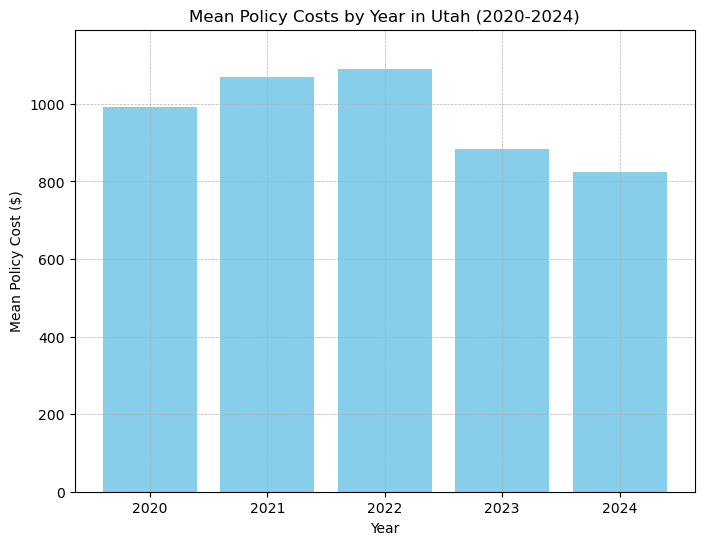

In [15]:
# Plotting the Mean Policy Cost as a bar chart
#Set figure size
plt.figure(figsize=(8, 6)) 

# Plots a bar chart where each bar represents the mean policy cost for a specific year.
plt.bar(df_annual_policy_stats['Year'].astype(str), df_annual_policy_stats['Mean Policy Cost'], color='skyblue')

# Set the title of the plot and add labels
plt.title('Mean Policy Costs by Year in Utah (2020-2024)')
plt.xlabel('Year')
plt.ylabel('Mean Policy Cost ($)')

# Sets the limits for the y-axis from 0 to slightly above the maximum value of 'Mean Policy Cost' in the data plus 100 dollars. 
plt.ylim(0, df_annual_policy_stats['Mean Policy Cost'].max() + 100) 
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

## Top 5 County Policy Cost Table
The following code example will pull the top 5 counties based on policy count (as of 2024) going back to 2020. 

In [16]:
import pandas as pd

# Dictionary mapping county codes to names
county_names = {
    '49001': 'Beaver',
    '49003': 'Box Elder',
    '49005': 'Cache',
    '49007': 'Carbon',
    '49009': 'Daggett',
    '49011': 'Davis',
    '49013': 'Duchesne',
    '49015': 'Emery',
    '49017': 'Garfield',
    '49019': 'Grand',
    '49021': 'Iron',
    '49023': 'Juab',
    '49025': 'Kane',
    '49027': 'Millard',
    '49029': 'Morgan',
    '49031': 'Piute',
    '49033': 'Rich',
    '49035': 'Salt Lake',
    '49037': 'San Juan',
    '49039': 'Sanpete',
    '49041': 'Sevier',
    '49043': 'Summit',
    '49045': 'Tooele',
    '49047': 'Uintah',
    '49049': 'Utah',
    '49051': 'Wasatch',
    '49053': 'Washington',
    '49055': 'Wayne',
}

policies_data['policyEffectiveDate'] = pd.to_datetime(policies_data['policyEffectiveDate'])
policies_data['policyTerminationDate'] = pd.to_datetime(policies_data['policyTerminationDate'], errors='coerce')
policies_data['policyCost'] = pd.to_numeric(policies_data['policyCost'], errors='coerce')

# Map county names to a new column
policies_data['County Name'] = policies_data['countyCode'].map(county_names)

# Subset policies data to those in force only
specific_date = '2024-01-01'
policies_in_force = policies_data[
        (policies_data['policyEffectiveDate'] <= specific_date) &
        (policies_data['policyTerminationDate'] >= specific_date) &
        (pd.isnull(policies_data['cancellationDateOfFloodPolicy']) | 
         (policies_data['cancellationDateOfFloodPolicy'] > specific_date))
    ]

# Aggregate and group by
policy_summary = policies_in_force.groupby(['countyCode', 'County Name']).agg(policyCount=('policyCount', 'sum')).reset_index()


# Identify top 5 counties by total policy count
top_counties = policy_summary.nlargest(5, 'policyCount')['countyCode']


# Filter policies to include only those from top counties
top_county_data = policies_data[policies_data['countyCode'].isin(top_counties)]

years = [2020, 2021, 2022, 2023, 2024]

annual_stats = []

# Calculate stats for each year and each top county
for year in years:
    specific_date = pd.Timestamp(year=year, month=1, day=1)
    
    for county in top_counties:
        policies_on_date = top_county_data[
            (top_county_data['countyCode'] == county) &
            (top_county_data['policyEffectiveDate'] <= specific_date) &
            ((top_county_data['policyTerminationDate'].isnull()) | 
             (top_county_data['policyTerminationDate'] >= specific_date))
        ]

        min_cost = policies_on_date['policyCost'].min()
        max_cost = policies_on_date['policyCost'].max()
        median_cost = policies_on_date['policyCost'].median()
        mean_cost = policies_on_date['policyCost'].mean()

        annual_stats.append({
            'Year': year,
            'County Code': county,
            'County Name': county_names[county],
            'Min Policy Cost': min_cost,
            'Max Policy Cost': max_cost,
            'Median Policy Cost': int(median_cost),
            'Mean Policy Cost': int(mean_cost)
        })

df_annual_stats = pd.DataFrame(annual_stats)

# Displaying the DataFrame using a pretty print for pandas DataFrame
with pd.option_context('display.max_columns', None, 'display.precision', 2):
    display(df_annual_stats)

,Year,County Code,County Name,Min Policy Cost,Max Policy Cost,Median Policy Cost,Mean Policy Cost
0,2020,49035,Salt Lake,99,21514,534,1189
1,2020,49049,Utah,99,10893,534,726
2,2020,49011,Davis,99,19595,534,811
3,2020,49043,Summit,217,23032,725,1911
4,2020,49053,Washington,180,13141,482,755
5,2021,49035,Salt Lake,77,43809,572,1383
6,2021,49049,Utah,103,11069,572,761
7,2021,49011,Davis,103,32427,572,1011
8,2021,49043,Summit,229,28726,741,1719
9,2021,49053,Washington,189,16352,516,817


## Box and Whisker Plots
Using our top 5 counties table, we can plot the results in a box-and-whisker plot to visualize the distribution of policy costs across the geographies. We remove outliervalues to simplify the interpretation.

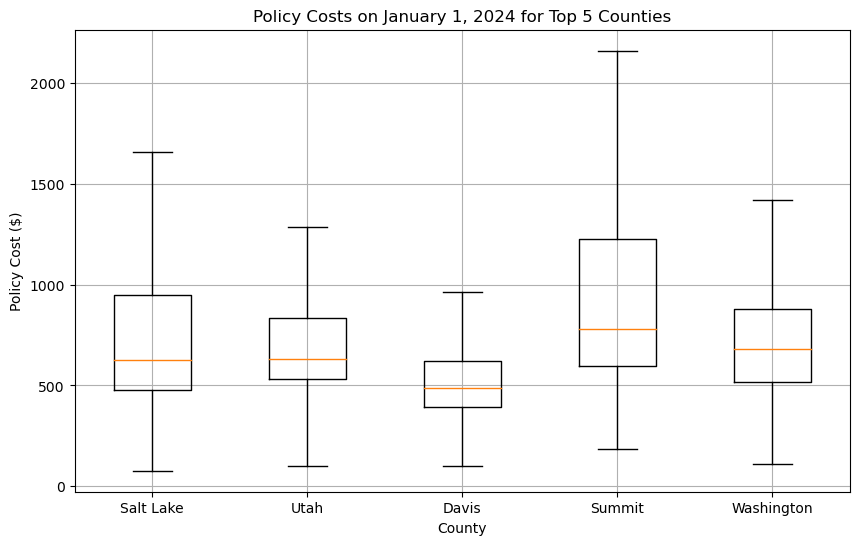

In [17]:
labels = [county_names[county] for county in top_counties if county in county_names]

# Prepare data for the box plot
boxplot_data = [top_county_data[top_county_data['countyCode'] == county]['policyCost'].dropna() for county in top_counties]
# boxplot_data

# Create the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(boxplot_data, labels=labels,showfliers=False)
plt.title('Policy Costs on January 1, 2024 for Top 5 Counties')
plt.ylabel('Policy Cost ($)')
plt.xlabel('County')
plt.grid(True)
plt.show()

## Community Policy Table
Using our policies in force subset, we can also aggregate by community.

In [18]:
# Aggregate and group by
community_summary = policies_in_force.groupby(['nfipRatedCommunityNumber', 'nfipCommunityName']).agg(policyCount=('policyCount', 'sum')).reset_index()

# Example output
community_summary.head()

,nfipRatedCommunityNumber,nfipCommunityName,policyCount
0,490001,BEAVER COUNTY*,3
1,490004,"NEW HARMONY, TOWN OF",5
2,490005,BOX ELDER COUNTY*,11
3,490006,"BRIGHAM CITY, CITY OF",26
4,490008,"HONEYVILLE, CITY OF",2


<div class="alert alert-block alert-info">
    <b>Tip:</b> Although the city field is currently unavailable, the community identifier and name can sometimes be used as a proxy for the city. 
</div>

## PIF in / out SFHA
We might also want to calculate the number of policies located inside and outside of the Special Flood Hazard Area (SFHA).  The code snippet below defines a function for the the SFHA which aliases the flood zone field before aggregating a count of policies in each grouping.

<div class="alert alert-block alert-info">
    <b>Tip:</b> The Special Flood Hazard Area (SFHA) is generally referred to as the area that will be inundated by the flood event having a 1-percent chance of being equaled or exceeded in any given year. The SFHA is identified by flood zones starting with the letter 'A' or 'V'.  
</div>

In [19]:
import numpy as np 

# Function to alias the first character
def sfha(flood_zone):
    if pd.isna(flood_zone) or flood_zone == '':
        return 'Unknown'
    #first_char = flood_zone[0].upper()  # Get the first character and convert to uppercase
    if flood_zone[0].upper() in 'AV':
        return 'SFHA'  # Alias for vowel
    else:
        return 'Non-SFHA'  # Alias for consonant

<div class="alert alert-block alert-warning">
    <b>Note:</b> Some policies lack flood zone information and are thus listed as "Unknown".
</div>

In [20]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
# Create a new variable defining SFHA
policies_in_force['SFHA'] = policies_in_force['ratedFloodZone'].apply(sfha)

In [21]:
# Aggregate and group by
fz_summary = policies_in_force.groupby(policies_in_force['SFHA']).agg(policyCount=('policyCount', 'sum')).reset_index()

# Example output
fz_summary.head()

,SFHA,policyCount
0,Non-SFHA,5455
1,SFHA,2030
2,Unknown,17


<div class="alert alert-block alert-warning">
    <b>Note: </b> We are providing much of the data as it is reported to our program by the NFIP Direct servicing agent and our private sector Write Your Own (WYO) partners. While the program’s PIVOT system has automated processes in place to reject or correct critical errors, it is still possible for some erroneous data to be allowed into the system. When taken together, this means that anomalous data can at times persist in our program’s records and that can be reflected in the data released through OpenFEMA and FloodSmart.
</div>

## Utah Policies in Force as of Jan 1, 2021 Map
Perhaps the best way to visualize spatial data is through a map. The following examples showcase potential visualizations using OpenFEMA and the *cenpy* and *geopandas* packages. 

C:\Users\mmatsuya\AppData\Roaming\Python\Python311\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


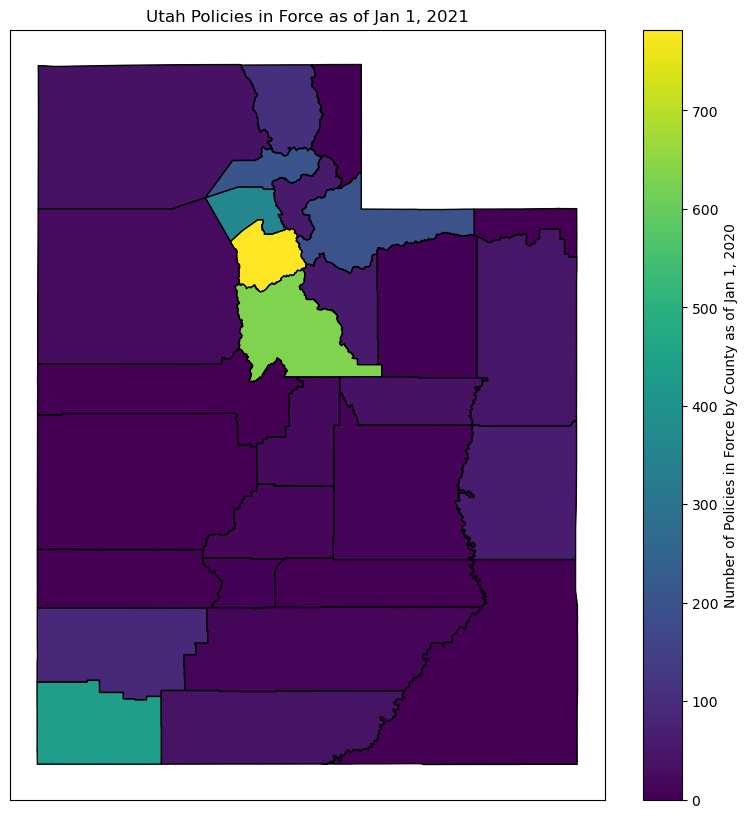

In [22]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cenpy as cp

# Convert date columns to datetime
policies_data['policyEffectiveDate'] = pd.to_datetime(policies_data['policyEffectiveDate'])
policies_data['policyTerminationDate'] = pd.to_datetime(policies_data['policyTerminationDate'], errors='coerce')

specific_date = pd.Timestamp('2021-01-01')

# Filter policies that are in force on January 1, 2021
policies_in_force = policies_data[
    (policies_data['policyEffectiveDate'] <= specific_date) &
    ((policies_data['policyTerminationDate'] > specific_date) | pd.isnull(policies_data['policyTerminationDate'])) &
    ((policies_data['cancellationDateOfFloodPolicy'] > specific_date) | pd.isnull(policies_data['cancellationDateOfFloodPolicy']))
]

# Aggregate the number of policies in force by county
policies_in_force_by_county = policies_in_force.groupby('countyCode').size().reset_index(name='PoliciesInForce')

# Access ACS data for Utah counties
acs = cp.products.ACS(2019)
variables = ['GEOID']  # Add more variables if needed
utah_counties_geo = acs.from_state('UT', level='county', variables=variables, return_geometry=True)

# Ensure GEOID is a string for merging
utah_counties_geo['GEOID'] = utah_counties_geo['GEOID'].astype(str)
policies_in_force_by_county['countyCode'] = policies_in_force_by_county['countyCode'].astype(str)

# Merge geographic data with policies in force data
merged_data = utah_counties_geo.merge(policies_in_force_by_county, left_on='GEOID', right_on='countyCode', how='left')

# Replace NaN values in 'PoliciesInForce' with 0 for counties without data
merged_data['PoliciesInForce'] = merged_data['PoliciesInForce'].fillna(0)

# Convert merged data to a GeoDataFrame for plotting
gdf = gpd.GeoDataFrame(merged_data, geometry='geometry')

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='PoliciesInForce', ax=ax, legend=True,
         edgecolor='black',  # Highlight county boundaries
         vmin=0, vmax=gdf['PoliciesInForce'].max(),  # Normalize the color scale
         legend_kwds={'label': 'Number of Policies in Force by County as of Jan 1, 2020'})
plt.title('Utah Policies in Force as of Jan 1, 2021')
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.show()

## Utah Policies in Force as of Jan 1, 2024 Map

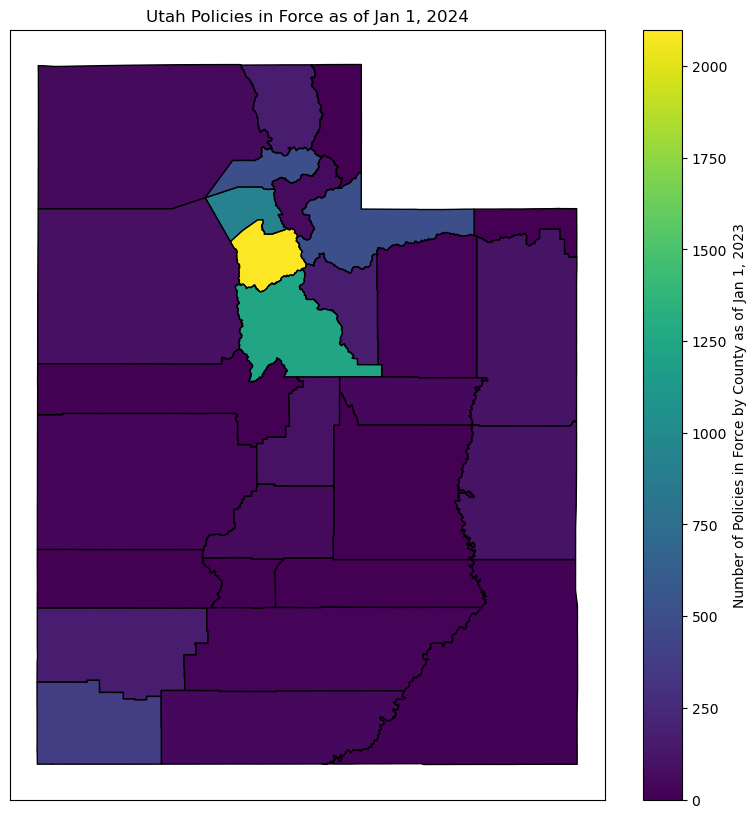

In [23]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cenpy as cp


policies_data['policyEffectiveDate'] = pd.to_datetime(policies_data['policyEffectiveDate'])
policies_data['policyTerminationDate'] = pd.to_datetime(policies_data['policyTerminationDate'], errors='coerce')

# Filter policies that are in force on January 1, 2024
specific_date = pd.Timestamp('2024-01-01')
policies_in_force = policies_data[
    (policies_data['policyEffectiveDate'] <= specific_date) &
    ((policies_data['policyTerminationDate'] > specific_date) | pd.isnull(policies_data['policyTerminationDate'])) &
    ((policies_data['cancellationDateOfFloodPolicy'] > specific_date) | pd.isnull(policies_data['cancellationDateOfFloodPolicy']))
]

# Aggregate the number of policies in force by county
policies_in_force_by_county = policies_in_force.groupby('countyCode').size().reset_index(name='PoliciesInForce')

# Access ACS data for Utah counties
acs = cp.products.ACS(2019)
variables = ['GEOID']  # Add more variables if needed
utah_counties_geo = acs.from_state('UT', level='county', variables=variables, return_geometry=True)

# Ensure GEOID is a string for merging
utah_counties_geo['GEOID'] = utah_counties_geo['GEOID'].astype(str)
policies_in_force_by_county['countyCode'] = policies_in_force_by_county['countyCode'].astype(str)

# Merge geographic data with policies in force data
merged_data = utah_counties_geo.merge(policies_in_force_by_county, left_on='GEOID', right_on='countyCode', how='left')

# Replace NaN values in 'PoliciesInForce' with 0 for counties without data
merged_data['PoliciesInForce'] = merged_data['PoliciesInForce'].fillna(0)

# Convert merged data to a GeoDataFrame for plotting
gdf = gpd.GeoDataFrame(merged_data, geometry='geometry')

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='PoliciesInForce', ax=ax, legend=True, 
         edgecolor='black',  # Highlight county boundaries
         vmin=0, vmax=gdf['PoliciesInForce'].max(),  # Normalize the color scale
         legend_kwds={'label': 'Number of Policies in Force by County as of Jan 1, 2023'})
plt.title('Utah Policies in Force as of Jan 1, 2024')
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.show()


## Year-over-Year 1-year policy growth map
What if we want to map the change in policyholders between 2021 and 2024? Notice that the scale bars differ between the two above maps and thus are difficult to compare. The below code snippet will save the 2021 data and 2024 data into separate objects, from which we can compare the time periods at a glance. 

In [24]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cenpy as cp

# Convert date columns to datetime
policies_data['policyEffectiveDate'] = pd.to_datetime(policies_data['policyEffectiveDate'])
policies_data['policyTerminationDate'] = pd.to_datetime(policies_data['policyTerminationDate'], errors='coerce')

specific_date = pd.Timestamp('2021-01-01')

# Filter policies that are in force on January 1, 2021
policies_in_force = policies_data[
    (policies_data['policyEffectiveDate'] <= specific_date) &
    ((policies_data['policyTerminationDate'] > specific_date) | pd.isnull(policies_data['policyTerminationDate'])) &
    ((policies_data['cancellationDateOfFloodPolicy'] > specific_date) | pd.isnull(policies_data['cancellationDateOfFloodPolicy']))
]

# Aggregate the number of policies in force by county
policies_in_force_by_county = policies_in_force.groupby('countyCode').size().reset_index(name='PoliciesInForce')

# Access ACS data for Utah counties
acs = cp.products.ACS(2019)
variables = ['GEOID']  # Add more variables if needed
utah_counties_geo = acs.from_state('UT', level='county', variables=variables, return_geometry=True)

# Ensure GEOID is a string for merging
utah_counties_geo['GEOID'] = utah_counties_geo['GEOID'].astype(str)
policies_in_force_by_county['countyCode'] = policies_in_force_by_county['countyCode'].astype(str)

# Merge geographic data with policies in force data
merged_data = utah_counties_geo.merge(policies_in_force_by_county, left_on='GEOID', right_on='countyCode', how='left')

# Replace NaN values in 'PoliciesInForce' with 0 for counties without data
merged_data['PoliciesInForce'] = merged_data['PoliciesInForce'].fillna(0)

# Convert merged data to a GeoDataFrame for plotting
gdf2021 = gpd.GeoDataFrame(merged_data, geometry='geometry')

# Filter policies that are in force on January 1, 2024
specific_date = pd.Timestamp('2024-01-01')
policies_in_force = policies_data[
    (policies_data['policyEffectiveDate'] <= specific_date) &
    ((policies_data['policyTerminationDate'] > specific_date) | pd.isnull(policies_data['policyTerminationDate'])) &
    ((policies_data['cancellationDateOfFloodPolicy'] > specific_date) | pd.isnull(policies_data['cancellationDateOfFloodPolicy']))
]

# Aggregate the number of policies in force by county
policies_in_force_by_county = policies_in_force.groupby('countyCode').size().reset_index(name='PoliciesInForce')

# Access ACS data for Utah counties
acs = cp.products.ACS(2019)
variables = ['GEOID']  # Add more variables if needed
utah_counties_geo = acs.from_state('UT', level='county', variables=variables, return_geometry=True)

# Ensure GEOID is a string for merging
utah_counties_geo['GEOID'] = utah_counties_geo['GEOID'].astype(str)
policies_in_force_by_county['countyCode'] = policies_in_force_by_county['countyCode'].astype(str)

# Merge geographic data with policies in force data
merged_data = utah_counties_geo.merge(policies_in_force_by_county, left_on='GEOID', right_on='countyCode', how='left')

# Replace NaN values in 'PoliciesInForce' with 0 for counties without data
merged_data['PoliciesInForce'] = merged_data['PoliciesInForce'].fillna(0)

# Convert merged data to a GeoDataFrame for plotting
gdf2024 = gpd.GeoDataFrame(merged_data, geometry='geometry')


Next, we create a new geo data frame differencing the two policy in force counts from the two years.

In [25]:
df_diff = gpd.GeoDataFrame({
    'GEOID':gdf2024['GEOID'],
    'geometry':gdf2024['geometry'],
    'NAME':gdf2024['NAME'],
    'state':gdf2024['state'],
    'county':gdf2024['county'],
    'countyCode':gdf2024['countyCode'],
    'PoliciesInForce2021':gdf2021['PoliciesInForce'],
    'PoliciesInForce2024':gdf2024['PoliciesInForce'],
    'Difference': gdf2024['PoliciesInForce'] - gdf2021['PoliciesInForce'] #difference the two policy in force counts
})

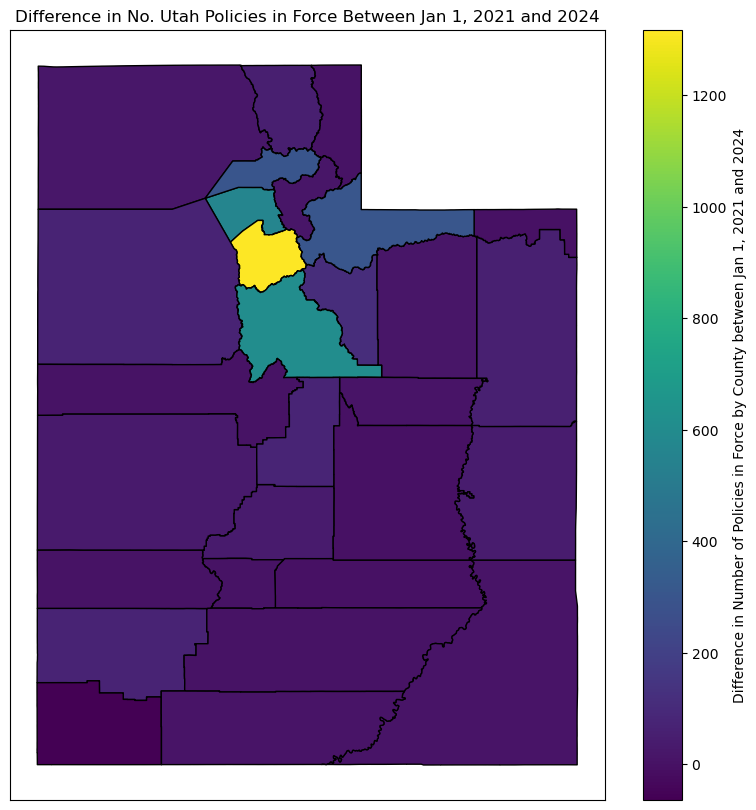

In [26]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
df_diff.plot(column='Difference', ax=ax, legend=True, #cmap='viridis',
         edgecolor='black',  # Highlight county boundaries
         vmin=df_diff['Difference'].min(),
         vmax=df_diff['Difference'].max(),  # Normalize the color scale
         legend_kwds={'label': 'Difference in Number of Policies in Force by County between Jan 1, 2021 and 2024'})
plt.title('Difference in No. Utah Policies in Force Between Jan 1, 2021 and 2024')
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.show()

## Utah Median Policy Cost as of Jan 1, 2021 Map
We can do the same thing with median policy costs. First we'll plot median policy costs in 2021.

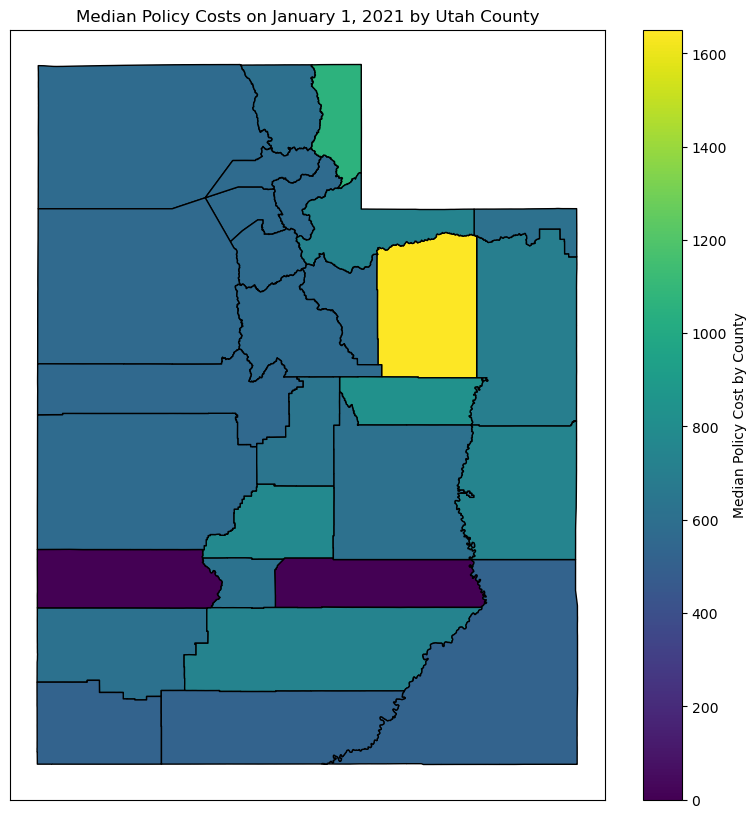

In [27]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cenpy as cp

# Assuming 'policies_data' contains your policy data with a 'countyCode' and 'policyCost' columns

# Access ACS data product
acs = cp.products.ACS(2019)

# Specify the variables you want to retrieve; 'GEOID' is necessary for merging
variables = ['GEOID', 'NAME']

# Get the geographic data for Utah counties
utah_counties_geo = acs.from_state('UT', level='county', variables=variables, return_geometry=True)

# Ensure the 'GEOID' column is a string to match the 'countyCode' data type
utah_counties_geo['GEOID'] = utah_counties_geo['GEOID'].astype(str)

# Convert 'policyEffectiveDate' and 'policyTerminationDate' to datetime, if not already done
policies_data['policyEffectiveDate'] = pd.to_datetime(policies_data['policyEffectiveDate'])
policies_data['policyTerminationDate'] = pd.to_datetime(policies_data['policyTerminationDate'], errors='coerce')

# Define the specific date for which you want the median policy cost
specific_date = pd.Timestamp('2021-01-01')

# Filter policies that are in force on January 1, 2021
policies_in_force_on_date = policies_data[
    (policies_data['policyEffectiveDate'] <= specific_date) &
    ((policies_data['policyTerminationDate'] > specific_date) | pd.isnull(policies_data['policyTerminationDate'])) &
    ((policies_data['cancellationDateOfFloodPolicy'] > specific_date) | pd.isnull(policies_data['cancellationDateOfFloodPolicy']))
]

# Calculate the median policy cost for each county
median_policy_cost_by_county = policies_in_force_on_date.groupby('countyCode')['policyCost'].median().reset_index()
median_policy_cost_by_county.columns = ['countyCode', 'MedianPolicyCost']

# Merge the geographic data with the median policy cost data
merged_data = utah_counties_geo.merge(median_policy_cost_by_county, left_on='GEOID', right_on='countyCode', how='left')

# Replace NaN values in 'MedianPolicyCost' with 0 for counties without data
merged_data['MedianPolicyCost'] = merged_data['MedianPolicyCost'].fillna(0)

# Convert merged data to a GeoDataFrame for plotting
gdf = gpd.GeoDataFrame(merged_data, geometry='geometry')

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='MedianPolicyCost', ax=ax, legend=True,
         edgecolor='black',  # This will highlight the county boundaries
         missing_kwds={'color': 'lightgrey'},  # Counties with no data will be light grey
         legend_kwds={'label': 'Median Policy Cost by County'})
plt.title('Median Policy Costs on January 1, 2021 by Utah County')
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.show()

## Median Policy Costs on January 1, 2024 by Utah County
Here we'll plot the same policy cost variable in 2024.

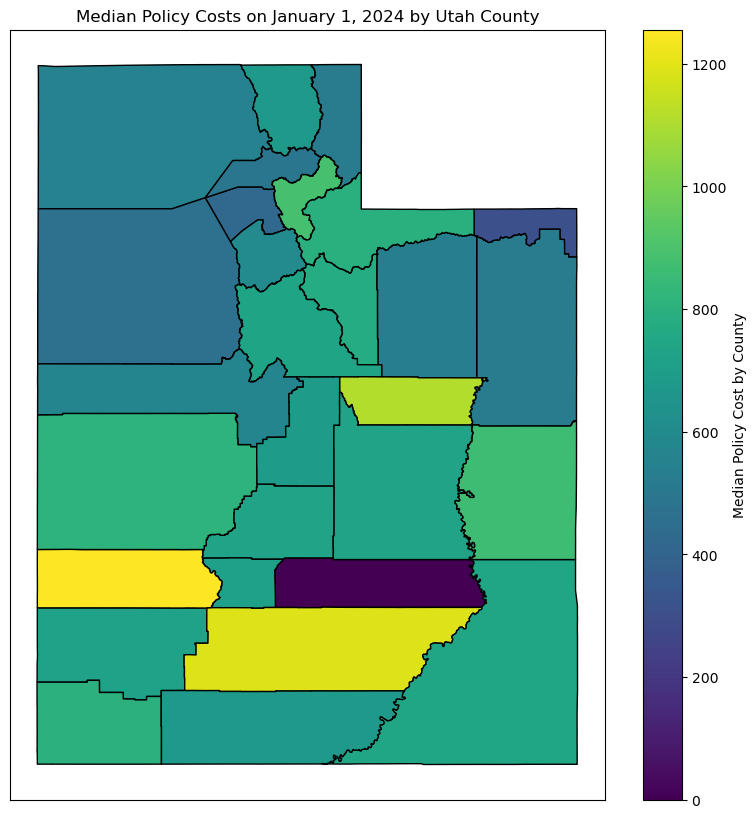

In [28]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cenpy as cp


# Access ACS data product
acs = cp.products.ACS(2019)

# Specify the variables you want to retrieve; 'GEOID' is necessary for merging
variables = ['GEOID', 'NAME']

# Get the geographic data for Utah counties
utah_counties_geo = acs.from_state('UT', level='county', variables=variables, return_geometry=True)

# Ensure the 'GEOID' column is a string to match the 'countyCode' data type
utah_counties_geo['GEOID'] = utah_counties_geo['GEOID'].astype(str)

# Convert 'policyEffectiveDate' and 'policyTerminationDate' to datetime, if not already done
policies_data['policyEffectiveDate'] = pd.to_datetime(policies_data['policyEffectiveDate'])
policies_data['policyTerminationDate'] = pd.to_datetime(policies_data['policyTerminationDate'], errors='coerce')

# Define the specific date for which you want the median policy cost
specific_date = pd.Timestamp('2024-01-01')

# Filter policies that are in force on January 1, 2023
policies_in_force_on_date = policies_data[
    (policies_data['policyEffectiveDate'] <= specific_date) &
    ((policies_data['policyTerminationDate'] > specific_date) | pd.isnull(policies_data['policyTerminationDate'])) &
    ((policies_data['cancellationDateOfFloodPolicy'] > specific_date) | pd.isnull(policies_data['cancellationDateOfFloodPolicy']))
]

# Calculate the median policy cost for each county
median_policy_cost_by_county = policies_in_force_on_date.groupby('countyCode')['policyCost'].median().reset_index()
median_policy_cost_by_county.columns = ['countyCode', 'MedianPolicyCost']

# Merge the geographic data with the median policy cost data
merged_data = utah_counties_geo.merge(median_policy_cost_by_county, left_on='GEOID', right_on='countyCode', how='left')

# Replace NaN values in 'MedianPolicyCost' with 0 for counties without data
merged_data['MedianPolicyCost'] = merged_data['MedianPolicyCost'].fillna(0)

# Convert merged data to a GeoDataFrame for plotting
gdf = gpd.GeoDataFrame(merged_data, geometry='geometry')

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='MedianPolicyCost', ax=ax, legend=True,
         edgecolor='black',  # This will highlight the county boundaries
         missing_kwds={'color': 'lightgrey'},  # Counties with no data will be light grey
         legend_kwds={'label': 'Median Policy Cost by County'})
plt.title('Median Policy Costs on January 1, 2024 by Utah County')
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)


# Save the plot to a PNG file
plt.savefig('myplot.png')

plt.show()


## Year-over-Year Median Policy Cost Map
Similar to our policy growth map, we greated above, we can also plot the change in median policy cost between the two time periods.

In [29]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cenpy as cp

# Access ACS data product
acs = cp.products.ACS(2019)

# Specify the variables you want to retrieve; 'GEOID' is necessary for merging
variables = ['GEOID', 'NAME']

# Get the geographic data for Utah counties
utah_counties_geo = acs.from_state('UT', level='county', variables=variables, return_geometry=True)

# Ensure the 'GEOID' column is a string to match the 'countyCode' data type
utah_counties_geo['GEOID'] = utah_counties_geo['GEOID'].astype(str)

# Convert 'policyEffectiveDate' and 'policyTerminationDate' to datetime, if not already done
policies_data['policyEffectiveDate'] = pd.to_datetime(policies_data['policyEffectiveDate'])
policies_data['policyTerminationDate'] = pd.to_datetime(policies_data['policyTerminationDate'], errors='coerce')

# Define the specific date for which you want the median policy cost
specific_date = pd.Timestamp('2021-01-01')

# Filter policies that are in force on January 1, 2021
policies_in_force_on_date = policies_data[
    (policies_data['policyEffectiveDate'] <= specific_date) &
    ((policies_data['policyTerminationDate'] > specific_date) | pd.isnull(policies_data['policyTerminationDate'])) &
    ((policies_data['cancellationDateOfFloodPolicy'] > specific_date) | pd.isnull(policies_data['cancellationDateOfFloodPolicy']))
]

# Calculate the median policy cost for each county
median_policy_cost_by_county = policies_in_force_on_date.groupby('countyCode')['policyCost'].median().reset_index()
median_policy_cost_by_county.columns = ['countyCode', 'MedianPolicyCost']

# Merge the geographic data with the median policy cost data
merged_data = utah_counties_geo.merge(median_policy_cost_by_county, left_on='GEOID', right_on='countyCode', how='left')

# Replace NaN values in 'MedianPolicyCost' with 0 for counties without data
merged_data['MedianPolicyCost'] = merged_data['MedianPolicyCost'].fillna(0)

# Convert merged data to a GeoDataFrame for plotting
gdf2021 = gpd.GeoDataFrame(merged_data, geometry='geometry')

# Access ACS data product
acs = cp.products.ACS(2019)

# Specify the variables you want to retrieve; 'GEOID' is necessary for merging
variables = ['GEOID', 'NAME']

# Get the geographic data for Utah counties
utah_counties_geo = acs.from_state('UT', level='county', variables=variables, return_geometry=True)

# Ensure the 'GEOID' column is a string to match the 'countyCode' data type
utah_counties_geo['GEOID'] = utah_counties_geo['GEOID'].astype(str)

# Convert 'policyEffectiveDate' and 'policyTerminationDate' to datetime, if not already done
policies_data['policyEffectiveDate'] = pd.to_datetime(policies_data['policyEffectiveDate'])
policies_data['policyTerminationDate'] = pd.to_datetime(policies_data['policyTerminationDate'], errors='coerce')

# Define the specific date for which you want the median policy cost
specific_date = pd.Timestamp('2024-01-01')

# Filter policies that are in force on January 1, 2023
policies_in_force_on_date = policies_data[
    (policies_data['policyEffectiveDate'] <= specific_date) &
    ((policies_data['policyTerminationDate'] > specific_date) | pd.isnull(policies_data['policyTerminationDate'])) &
    ((policies_data['cancellationDateOfFloodPolicy'] > specific_date) | pd.isnull(policies_data['cancellationDateOfFloodPolicy']))
]

# Calculate the median policy cost for each county
median_policy_cost_by_county = policies_in_force_on_date.groupby('countyCode')['policyCost'].median().reset_index()
median_policy_cost_by_county.columns = ['countyCode', 'MedianPolicyCost']

# Merge the geographic data with the median policy cost data
merged_data = utah_counties_geo.merge(median_policy_cost_by_county, left_on='GEOID', right_on='countyCode', how='left')

# Replace NaN values in 'MedianPolicyCost' with 0 for counties without data
merged_data['MedianPolicyCost'] = merged_data['MedianPolicyCost'].fillna(0)

# Convert merged data to a GeoDataFrame for plotting
gdf2024 = gpd.GeoDataFrame(merged_data, geometry='geometry')


In [30]:
df_diff = gpd.GeoDataFrame({
    'GEOID':gdf2024['GEOID'],
    'geometry':gdf2024['geometry'],
    'NAME':gdf2024['NAME'],
    'state':gdf2024['state'],
    'county':gdf2024['county'],
    'countyCode':gdf2024['countyCode'],
    'MedianPolicyCost2021':gdf2021['MedianPolicyCost'],
    'MedianPolicyCost2024':gdf2024['MedianPolicyCost'],
    '% Difference': (gdf2024['MedianPolicyCost'] - gdf2021['MedianPolicyCost'])/gdf2021['MedianPolicyCost'] #difference the two policy in force counts
})

In [31]:
# Replace NaN values in '% Difference' with 0 for counties without data
df_diff['% Difference'] = df_diff['% Difference'].fillna(0)

In [32]:
df_diff

,GEOID,geometry,NAME,state,county,countyCode,MedianPolicyCost2021,MedianPolicyCost2024,% Difference
0,49011,"POLYGON ((-12449269.200 5017802.460, -12449305...","Davis County, Utah",49,011,49011,572.0,421.0,-0.26
1,49041,"POLYGON ((-12482703.230 4712429.980, -12482697...","Sevier County, Utah",49,041,49041,779.0,728.0,-0.07
2,49047,"POLYGON ((-12235560.940 4980305.410, -12235536...","Uintah County, Utah",49,047,49047,702.0,517.0,-0.26
3,49003,"POLYGON ((-12467720.180 5097672.820, -12467703...","Box Elder County, Utah",49,003,49003,572.0,552.0,-0.03
4,49005,"POLYGON ((-12470222.310 5127901.680, -12470185...","Cache County, Utah",49,005,49005,604.0,673.0,0.11
5,49029,"POLYGON ((-12451778.340 5032869.940, -12451780...","Morgan County, Utah",49,029,49029,572.0,885.0,0.55
6,49013,"POLYGON ((-12252192.400 4837833.390, -12252235...","Duchesne County, Utah",49,013,49013,1651.0,534.0,-0.68
7,49035,"POLYGON ((-12487416.280 4953108.490, -12487409...","Salt Lake County, Utah",49,035,49035,572.0,594.0,0.04
8,49051,"POLYGON ((-12420022.570 4943657.450, -12420023...","Wasatch County, Utah",49,051,49051,576.0,770.5,0.34
9,49055,"POLYGON ((-12409153.000 4651735.310, -12409020...","Wayne County, Utah",49,055,NaN,0.0,0.0,0.00


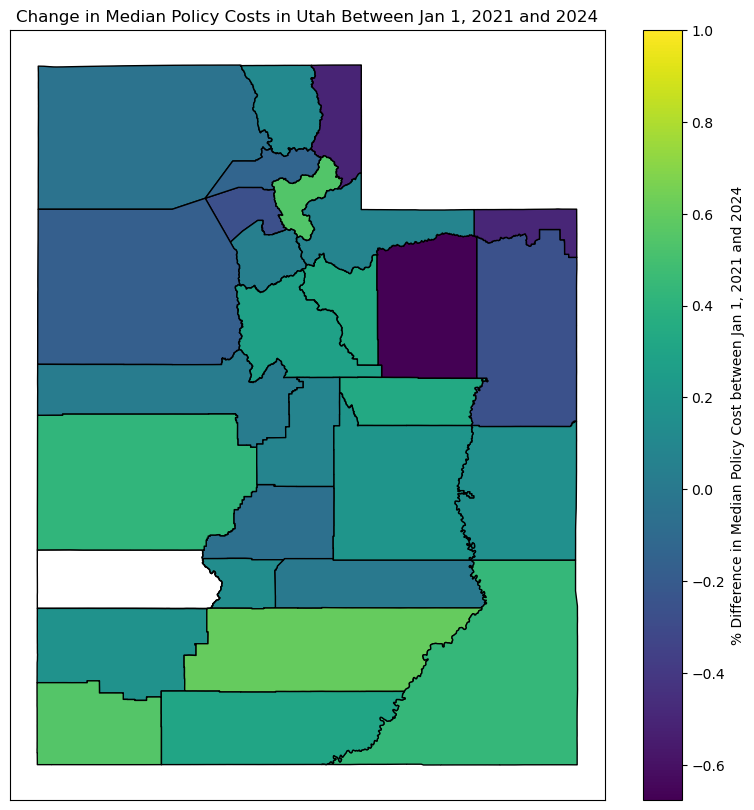

In [33]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
df_diff.plot(column='% Difference', ax=ax, legend=True, 
         edgecolor='black',  # Highlight county boundaries
         vmin=df_diff['% Difference'].min(),
         vmax=1,  # Normalize the color scale
         legend_kwds={'label': '% Difference in Median Policy Cost between Jan 1, 2021 and 2024'})
plt.title('Change in Median Policy Costs in Utah Between Jan 1, 2021 and 2024')
plt.show()

<div class="alert alert-block alert-info">
    <b>Tip:</b> The above mapping examples retrieve data from the OpenFEMA API multiple times. If you need to perform various analysis on the same set of data, it is strongly advised that you first download the data and save it to a file - especially if it is a large amount of data. If your program crashes partway through, you will need to download data again.
</div>
<div class="alert alert-block alert-info">
    <b>Tip:</b> When downloading data to a file, specify your prefered file type using the \$format argument rather than converting within Python. OpenFEMA currently supports JSON, JSONA, JSONL, GeoJson (where applicable), CSV, and Parquet file formats. 
</div>

## Where to go Next
 - Review the NFIP Claims Demo Jupyter notebook
 - See the [OpenFEMA API Tutorials on GitHub](https://github.com/FEMA/openfema-samples) in the analysis-examples folder

## Other Resources
- [FloodSmart Reports](https://nfipservices.floodsmart.gov//reports-flood-insurance-data)
- [National Flood Insurance Program](https://www.fema.gov/flood-insurance)
- [OpenFEMA API Documentation](https://www.fema.gov/about/openfema/api)
- [US Census Python Library (cenpy)](https://pypi.org/project/cenpy/)

## Acknowledgements
Special thanks to Lilian Chiang, 2024 Virtual Student Federal Service (VSFS) intern, whose hard work and insights were crucial in creating this Jupyter notebook.